<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Setup and Data Preparation

Before diving into the model, let's set up our environment and prepare the data. We'll first load the necessary libraries and print out library versions.

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
torchinfo version :  1.8.0
numpy version :  1.26.3
matplotlib version :  3.9.2
Python 3.11.0


Let's also check if GPUs are available and set our device accordingly.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


The data is in the `data_p2` directory within which is the `data_undersampled` directory. In that folder we have the `train` subdirectory that contains the training data.

**Task 2.5.1:** Assign `data_dir` the path to the training data using `os.path.join`.

In [4]:
data_dir = os.path.join("data_p2", "data_undersampled", "train")

print("Data Directory:", data_dir)

Data Directory: data_p2/data_undersampled/train


You may remember that images from each class are contained in separate subdirectories within `data_dir`, where the name of each subdirectory is the name of the class.

**Task 2.5.2:** Create a list of class names in this data using `os.listdir`.

In [5]:
classes = os.listdir(data_dir)

print("List of classes:", classes)

List of classes: ['cassava-healthy', 'cassava-mosaic-disease-cmd', 'cassava-brown-streak-disease-cbsd', 'cassava-green-mottle-cgm', 'cassava-bacterial-blight-cbb']


As in the previous lessons, we'll standardize the images using the following set of transformations:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values
- Normalize the data

Here's the custom transformation that we've used before which converts images to RGB format:

In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

Now let's make the transformation pipeline. In the normalization step, use the `mean` and `std` values from our previous lesson.

**Task 2.5.3:** Create the transformation pipeline using `transforms.Compose` from `torchvision` package. Follow what we did in the previous lessons.

In [7]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4326, 0.4952, 0.3120], [0.2179, 0.2214, 0.2091]),
    ]
)

print(type(transform_normalized))
print("----------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
----------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4952, 0.312], std=[0.2179, 0.2214, 0.2091])
)


Let's create the dataset and apply our transformations.

**Task 2.5.4:** Make a dataset using `ImageFolder` from `datasets` and make sure to apply `transform_normalized` transformation pipeline. Then print the length of the dataset.

In [8]:
normalized_dataset = datasets.ImageFolder(root=data_dir, transform =transform_normalized)


print('Length of dataset:', len(normalized_dataset))

Length of dataset: 7615


### Making a train/validation split

As usual, we'll divide our data into two parts. One part is for training the model, the other part is for evaluating it on unseen images.

**Task 2.5.5:** Use `random_split` to create a 80/20 split (training dataset should have 80% of the data, validation dataset should have 20% of the data).

<div class="alert alert-info" role="alert">
    <p><b>About random number generators</b></p>
<p>The following cell adds a <code>generator=g</code> line of code that is not present in the video. This is something we have added to make sure you always get the same results in your predictions. Please don't change it or remove it.
</p>
</div>

In [10]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(normalized_dataset,[0.8,0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

percent_train = np.round(100 * len(train_dataset) / len(normalized_dataset), 2)
percent_val = np.round(100 * len(val_dataset) / len(normalized_dataset), 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Length of training dataset: 6092
Length of validation dataset: 1523
Train data is 80.0% of full data
Validation data is 20.0% of full data


Let's again check how the observations are distributed across classes. We'll reuse the `class_counts` function from `training.py` that we used previously. We want to check the distribution of the training and the validation data.

**Task 2.5.6:** Use `class_counts` function on the `train_dataset` and visualize the results with a bar chart.

  0%|          | 0/6092 [00:00<?, ?it/s]

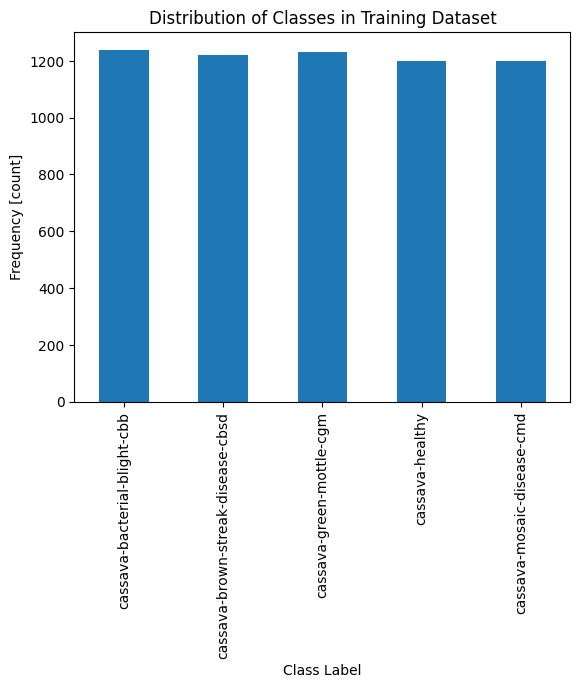

In [12]:
from training import class_counts

train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

**Task 2.5.7:** Use the `class_counts` function on the validation split. Make sure to again visualize the results with a bar chart.

In [ ]:
val_counts = ...

# Make a bar chart from the function output

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

Now let's create `DataLoader` objects. We'll use a batch size of 32 and create one `DataLoader` for training and another for validation data. Remember that in training we want to shuffle the data after each epoch and in validation we don't.

**Task 2.5.8:** Create the training loader (with shuffling on) and the validation loader (with shuffling off).

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False)

print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


### Model Selection for Transfer Learning

When we're using Transfer Learning, choosing the right pre-trained model is crucial. We'll select the same model as in the previous lesson. This model has been trained on a large and diverse dataset, ensuring it has learned features that are broadly applicable to various tasks, including ours.

**Task 2.5.9:** Define a `resnet50` model in the same way we defined it in the previous lesson.

In [15]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In Transfer Learning, we don't want to tweak the model weights when we train the model on our data. So let's make sure the weights are fixed! 
 

**Task 2.5.10:** Fix the parameters of the model such that they'll not be updated once we train the model on our task. Remember how we did this in the previous lesson?

In [16]:
# Freeze the models weights
for params in model.parameters():
    params.requires_grad=False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Same as we did before, we now want to change the output layer of the model (layer `model.fc`). We want to replace it with a dense layer and an output layer. 

But we need to know how many features will be going into the dense layer that we want to add. This means we should first compute the number of features going into the last layer of the original model.

**Task 2.5.11:** Compute the number of features going into the last layer of the original model.

In [17]:
in_feat = model.fc.in_features

print(in_feat)

2048


Well done! Now we can change the last layer (layer `model.fc`). We want to change it to:
- a dense layer with 256 neurons
- followed by ReLU activation
- then add `p=0.5` of Dropout
- followed by the output layer with 5 neurons (because our data has 5 classes)

**Task 2.5.12:** Fill in the missing parts of code below that changes the last layer of the original model.

In [18]:
modified_last_layer = nn.Sequential()

modified_last_layer.append(nn.Linear(in_feat, 256))

relu = nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

linear = nn.Linear(256,5)
modified_last_layer.append(linear)

model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Observe how the last layer of the model is now different and exactly what we wanted.

We're ready to start fitting!

### Training the Model

As always, before we start training, we need to define the loss and what optimizer we'll use. For loss function we'll go with cross entropy. For the optimizer we'll choose the Adam optimizer as we've done before.

**Task 2.5.13:** Define cross-entropy as the loss function and set Adam optimizer to be the optimizer. You can use the default learning rate and `weight_decay=1e-4`.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


Next let's make sure that we use the GPU that we have at our disposal. 

**Task 2.5.14:** Place our model on `device`. The code we provided below prints out the device that the model is on.

In [20]:
# Place model on device
model.to(device)
print(next(model.parameters()).device)

cuda:0


Before we continue, let's get more information about our model by calling the `summary` function on the model. You may remember that we've seen this function before. This function requires us to pass in two things: the model itself and the size of input tensors.

**Task 2.5.15:** Complete the `input_size` tuple that we are passing to `summary` function in the code below.

In [21]:
height = 224
width = 224

summary(model, input_size=(batch_size, 3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

Among other things, the output of the summary displays the amount of trainable parameters the model has. And it has many! 

While we added Dropout, which helps with preventing overfitting, we'll go further and take another step to make sure we don't overfit. When we fit, we'll check model performance at every epoch and stop fitting when the model stops improving. This brings us to callbacks!

### Training the Model with Callbacks

During the training of our model, we can use various callbacks. Callbacks allow us to customize and control the training process in fine-grained ways. We'll implement three key callbacks:
        
- **Learning Rate Scheduling**: Adjusts the learning rate over time, which can lead to better model performance.
- **Early Stopping**: Halts training when the model's performance stops improving, which prevents overfitting. We'll stop if validation loss doesn't improve for at least 5 epochs.
- **Checkpointing**: Saves the model every time validation loss gets better than in the epoch prior. This allows us to recover the best model once training completes.

In order to use these callbacks, we need to implement them and then update the `train` function. 

For the Learning Rate Scheduling, we'll use `StepLR` from `torch.optim`. The `StepLR` scheduler decays the learning rate by multiplicative factor `gamma` every `step_size` epochs. 

**Task 2.5.16:** Set `step_size` to $4$ and `gamma` factor to $0.2$. The rest of the code creates a `StepLR` Learning Rate Scheduler.

In [22]:
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


For Early Stopping, we'll create a function `early_stopping` that we'll call from within the `train` function. The `early_stopping` function accepts:
- the current validation loss,
- the best validation loss so far
- the number of epochs since validation loss last improved (counter).

In the function we need to check if validation loss improved. If yes, we reset the counter. If not, we add one to the counter. We also need to check if validation loss hasn't improved in the last 5 epochs. If that is the case, we should set stopping to `True`. 

**Task 2.5.17:** Fill in the missing code in the definition of the `early_stopping` function below.

In [ ]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter>=5:
        stop =True

    return counter, stop


early_stopping?

Now we'll define a function that will take care of Checkpointing. In this function we need to check if validation loss improved. If yes, we save the model.

In [24]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

Now we're ready to modify the `train` function to include an option to use Callbacks. 

Notice that the modified `train` function below is quite similar to what we've used before. We just added `scheduler`, `checkpoint_path` and `early_stopping` as optional arguments. As you can see at the end of the modified `train` function, we use these three callbacks when function is called with appropriate inputs.

In [ ]:
from training import score, train_epoch


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

With our model and callbacks ready, we'll proceed to train the model. During this phase, we'll observe how callbacks affect the training process and ultimately, the model's performance. 

Because we implemented early stopping, the model will stop training once its performance no longer improves. So we can set off to train for many epochs and training will stop when the model stops improving.

**Task 2.5.18:** Define the number of training epochs to equal 50. The rest of the code provided below will call the `train` function and start the training. Note that this can take a while to run.

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

This task involves training the model for (at least) 50 epochs. This might take more than 60 minutes. Instead, we recommend you to skip the training process and load the pre-trained model that we have made available in the next few cells.

<b>We strongly recommend you to use the saved model instead of training your own</b>
</div>

In [ ]:
epochs_to_train = ...

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

**[RECOMMENDED]** Load the pre-trained model:

In [25]:
epochs = 15
model = torch.load("model_trained.pth", weights_only=False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Looks like the training indeed didn't go over all 50 epochs, but stopped earlier.

In [ ]:
print(f"Training went on for {epochs} number of epochs before it stopped.")

### Evaluation of the Training Process and the Model

Now that the training's finished, we'll evaluate our model's performance and draw conclusions. We'll see how effectively our callbacks contributed to the training process and discuss the results. Let's first plot the learning curve!

In [26]:
import pandas as pd

eval_metrics_df = pd.read_csv("pretrained_model_evaluation_metrics.csv")
train_losses = eval_metrics_df['train_losses'].values
valid_losses = eval_metrics_df['valid_losses'].values
train_accuracies = eval_metrics_df['train_accuracies'].values
valid_accuracies = eval_metrics_df['valid_accuracies'].values
learning_rates = eval_metrics_df['learning_rates'].dropna().values

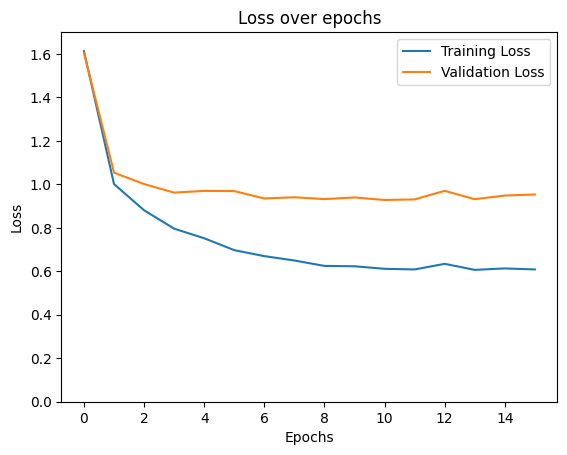

In [27]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

**Task 2.5.19:** Complete the code below to plot train and validation accuracies. You can follow what we did above for plotting train and validation losses.

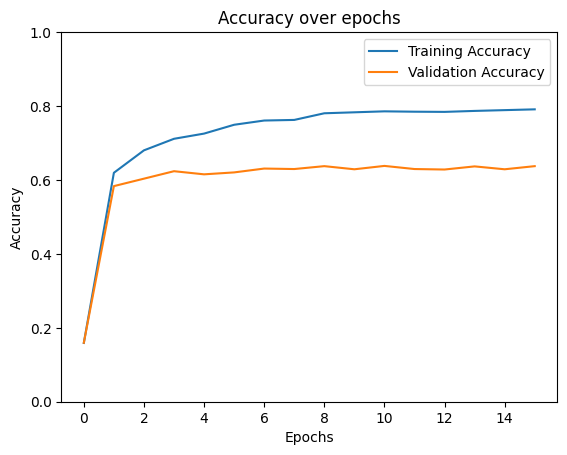

In [29]:
# Plot train accuracies, use label="Training Accuracy"
plt.plot(train_accuracies, label ="Training Accuracy")
# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies, label = "Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

From the learning curve we see that overall training loss decreases and accuracy increases. Validation loss does not seem to improve that much beyond the first couple of epochs.

Let's also inspect how the learning rate was changing during training due to the fact that we used a Learning Rate Scheduling Callback.

In [ ]:
# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

As expected, the learning rate decreases as our training progresses.

Now it's time load the best model that we saved with checkpointing!

In [30]:
checkpoint = torch.load("model/LR_model.pth")

# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

Let's compute the confusion matrix for our model using the validation data, like we did in previous lessons.

We'll obtain the probabilities that our model predicts by using the `predict` function from `training.py`. This function expects the model, the loader and the device as input arguments.

**Task 2.5.20:** Use the `predict` function from `training.py` to compute probabilities that our model predicts on the validation data. Then use `torch.argmax` and take these probabilities to compute the predicted classes.

In [31]:
from training import predict

probabilities_val = predict(model, val_loader,device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/48 [00:00<?, ?it/s]

tensor([3, 4, 4,  ..., 4, 0, 3], device='cuda:0')


Now we'll get the target values and compute the confusion matrix. Again, same as we've done before.

Get Labels: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


<Figure size 1000x800 with 0 Axes>

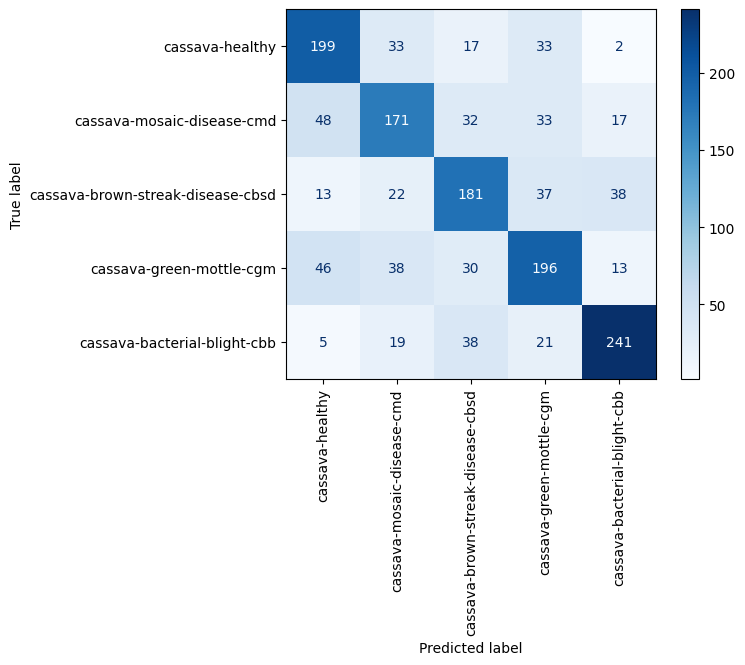

In [32]:
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

Well done, looks good! We're ready to use this model on our test set and prepare a CSV file that we can submit to the competition.

### Submission to Competition

The competition submission should contain predicted probabilities for each of the $5$ classes on a test set. So we'll need to run each test image through our model.

Let's first find the test images. They are located in the `test` subdirectory within the `data_p2` directory.

**Task 2.5.21:** Assign `test_dir` the path to the test data using `os.path.join`.

In [33]:
test_dir = os.path.join("data_p2", "test")

print(test_dir)

data_p2/test


In [41]:
len(os.listdir(test_dir))

150

The competition requires us to save the model predictions as a CSV file. The first column should be called ID and contains the image filename. The rest of the columns should be labeled by the class name.

In order to get predicted probabilities of our model, we'll create a function `file_to_confidence` which is similar to what we created for this purpose in Project 1. The function makes model predictions on a single image. The steps in the function are:
- Open the image.
- Apply our transformation pipeline to the image as our model expects.
- Use `unsqueeze` to change the image tensor to 4D ($1$ x $3$ x $224$ x $224$) as our model is expecting a batch of images.
- Place image on device we're using.
- Make prediction and pass it through a `SoftMax` to get probabilities (numbers between $0$ and $1$, that sum to $1$).
- Convert result to a DataFrame

In [34]:
model.to(device)


def file_to_confidence(model, datadir, filename, transform_pipeline):
    file_path = os.path.join(datadir, filename)
    image = PIL.Image.open(file_path)
    transformed = transform_pipeline(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame([[filename] + confidence.tolist()[0]])
    conf_df.columns = ["ID"] + train_dataset.dataset.classes

    return conf_df

Just to make sure this is working, let's call this function on a training image from the cassava mosaic disease class for example.

In [35]:
mosaic_train_dir = os.path.join("data_p2", "train", "cassava-mosaic-disease-cmd")
mosaic_images = os.listdir(mosaic_train_dir)

file_to_confidence(model, mosaic_train_dir, mosaic_images[0], transform_normalized)

,ID,cassava-bacterial-blight-cbb,cassava-brown-streak-disease-cbsd,cassava-green-mottle-cgm,cassava-healthy,cassava-mosaic-disease-cmd
0,3598252026.jpg,0.006932,0.00159,0.126984,0.00166,0.862834


Looks alright! The largest predicted probability on this mosaic image is for the mosaic disease class.

Let's try one more.

In [36]:
file_to_confidence(model, mosaic_train_dir, mosaic_images[1], transform_normalized)

,ID,cassava-bacterial-blight-cbb,cassava-brown-streak-disease-cbsd,cassava-green-mottle-cgm,cassava-healthy,cassava-mosaic-disease-cmd
0,3709699332.jpg,0.029583,0.038606,0.254081,0.005833,0.671898


Everything seems in order. Now let's use `file_to_confidence` function on each test image to get the predictions for the competition submission. We can loop over the filenames and build up a list of DataFrames.

**Task 2.5.22:** Fill in the missing code below and use `pd.concat` to assemble the list of DataFrames `small_dfs` into one big DataFrame.

In [37]:
small_dfs = []

for filename in tqdm(os.listdir(test_dir), desc="Predicting on test set"):
    small_dfs.append(
        file_to_confidence(model, test_dir, filename, transform_normalized)
    )

confidence_df = pd.concat(small_dfs)

confidence_df = confidence_df.sort_values("ID").reset_index(drop=True)
confidence_df.head()

Predicting on test set: 100%|██████████| 150/150 [00:04<00:00, 30.80it/s]


,ID,cassava-bacterial-blight-cbb,cassava-brown-streak-disease-cbsd,cassava-green-mottle-cgm,cassava-healthy,cassava-mosaic-disease-cmd
0,001.jpg,0.006743,0.063323,0.921228,0.004969,0.003738
1,002.jpg,0.838493,0.104554,0.007242,0.047940,0.001770
2,003.jpg,0.463756,0.046256,0.011856,0.478017,0.000115
3,004.jpg,0.021102,0.021519,0.534750,0.032366,0.390263
4,005.jpg,0.008434,0.020538,0.719296,0.223105,0.028627


In [38]:
confidence_df.shape

(150, 6)

Finally, save the dataframe as a CSV in `submission.csv`.

In [43]:
confidence_df.to_csv("submission.csv", index=False)

### Conclusion

Great! 🎉 We accomplished a lot in this notebook. Here are the key takeaways:

- We used Transfer Learning to take a large existing model and specialize it to our competition.
- We trained that model with the balanced dataset we created in an earlier lesson.
- We implemented Callbacks using additional code in the training loop.
- The Callbacks we implemented were: Learning Rate Scheduling, Checkpointing, and Early Stopping.
- By reformatting the predictions of the model on the test set, we obtained a CSV file for competition submission.


---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).